In [1]:
%cd ..

/mnt/e/projects/face_recognition


In [2]:
import os

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from albumentations.pytorch import ToTensorV2
from IPython.display import clear_output
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import Dataset

from config import CFG

device = "cuda"

In [3]:
class celebAIrDataset(Dataset):
    def __init__(self, images_list):
        self.images = images_list
        self.transform = A.Compose(
            [
                # A.Resize(height=128, width=128),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ]
        )

    def __len__(self):
        return len(self.images)

    def get_img(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return self.transform(image=img)["image"]

    def get_tensors(self):
        images = torch.stack([self.get_img(img_name) for img_name in self.images])
        return images

    def __getitem__(self, idx):
        img_name = self.images[idx]
        return self.get_img(img_name)

In [4]:
def compute_embeddings(model, images_list):
    """
    compute embeddings from the trained model for list of images.
    params:
      model: trained nn model that takes images and outputs embeddings
      images_list: list of images paths to compute embeddings for
    output:
      list: list of model embeddings. Each embedding corresponds to images
            names from images_list
    """
    data = celebAIrDataset(images_list)

    model.to(device)

    # loader = torch.utils.data.DataLoader(data.get_tensors(), batch_size=32, shuffle=False)
    loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=False)

    model.eval()
    embeddings = []
    with torch.no_grad():
        for x in loader:
            outputs = model(x.to(device))
            embeddings.append(outputs.cpu())
    return torch.cat(embeddings)

In [5]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    """
    compute cosine similarities between positive pairs from query (stage 1)
    params:
      query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                  the dataset. Value: images corresponding to that class
      query_img_names: list of images names
      query_embeddings: list of embeddings corresponding to query_img_names
    output:
      list of floats: similarities between embeddings corresponding
                      to the same people from query list
    """
    full_embeddings = torch.Tensor()

    for person_class in query_dict:
        images = [os.path.join(CFG.img_folder_dst, x) for x in query_dict[person_class]]
        person_embeddings = []
        for image_path in images:
            person_embeddings.append(torch.Tensor(query_embeddings[query_img_names.index(image_path)]))
        if len(person_embeddings) == 0:
            person_embeddings = torch.Tensor
            result = 0.0
        else:
            person_embeddings = torch.stack(person_embeddings)
            result = cosine_similarity(np.array(person_embeddings), np.array(person_embeddings))
            df = pd.DataFrame(result)

            df = df.mask(np.tril(np.ones(df.shape, dtype=np.bool_))).values.reshape(-1)  # get triangle values
            useful_result = df[~np.isnan(df)]  # drop nan

            useful_result = torch.Tensor(useful_result).view(-1)
            full_embeddings = torch.cat((full_embeddings, useful_result))
    results = [i.item() for i in full_embeddings]
    plt.hist(results)
    plt.show()
    print("Count of cosine similarities =", len(results))
    return results

In [6]:
def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    """
    compute cosine similarities between negative pairs from query (stage 2)
    params:
      query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                  the dataset. Value: images corresponding to that class
      query_img_names: list of images names
      query_embeddings: list of embeddings corresponding to query_img_names
    output:
      list of floats: similarities between embeddings corresponding
                      to different people from query list
    """

    full_embeddings = torch.Tensor()
    class_counter = []

    k = 0
    for person_class in query_dict:
        k += 1
        print("Analyse {} person of {}...".format(k, len(query_dict)))
        images = [os.path.join(CFG.img_folder_dst, x) for x in query_dict[person_class]]
        class_counter.extend([person_class for _ in range(len(images))])

        person_embeddings = []
        for image_path in images:
            person_embeddings.append(torch.Tensor(query_embeddings[query_img_names.index(image_path)]))
        if len(person_embeddings) == 0:
            person_embeddings = torch.Tensor
        else:
            person_embeddings = torch.stack(person_embeddings)
            full_embeddings = torch.cat((full_embeddings, person_embeddings))
        clear_output(wait=True)

    # all_data = pd.DataFrame(data={"class": class_counter, "embeddings": list(full_embeddings)})
    results = cosine_similarity(full_embeddings, full_embeddings)
    results = pd.DataFrame(data=results, index=class_counter, columns=class_counter)

    k = 0
    for i in results:
        k += 1
        print("Analyse {} row of {}...".format(k, len(results)))
        results.loc[i, i] = np.nan
        clear_output(wait=True)

    df = results.mask(np.tril(np.ones(results.shape, dtype=np.bool_))).values.reshape(-1)  # get triangle values
    useful_result = df[~np.isnan(df)]  # drop nan
    plt.hist(useful_result)
    plt.show()
    print("Count of cosine similarities =", len(useful_result))
    return useful_result

In [7]:
def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    """
    compute cosine similarities between negative pairs from query and distractors
    (stage 3)
    params:
      query_embeddings: list of embeddings corresponding to query_img_names
      distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
      list of floats: similarities between pairs of people (q, d), where q is
                      embedding corresponding to photo from query, d —
                      embedding corresponding to photo from distractors
    """
    results = cosine_similarity(query_embeddings, distractors_embeddings)
    results = results.reshape(-1)
    plt.hist(results)
    plt.show()
    print("Count of cosine similarities =", len(results))
    return results

In [8]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=0.1):
    """
    compute identification rate using precomputer cosine similarities between pairs
    at given fpr
    params:
      cosine_query_pos: cosine similarities between positive pairs from query
      cosine_query_neg: cosine similarities between negative pairs from query
      cosine_query_distractors: cosine similarities between negative pairs
                                from query and distractors
      fpr: false positive rate at which to compute TPR
    output:
      float: threshold for given fpr
      float: TPR at given FPR
    """
    cosine_query_pos = torch.Tensor(cosine_query_pos)
    cosine_query_neg = torch.Tensor(cosine_query_neg)
    cosine_query_distractors = torch.Tensor(cosine_query_distractors)

    false_pairs = torch.cat((cosine_query_neg, cosine_query_distractors))
    N = round(fpr * len(false_pairs))
    false_pairs = torch.sort(false_pairs, descending=True)[0]
    threshold = false_pairs[N]
    TPR = len(cosine_query_pos[cosine_query_pos > threshold]) / len(cosine_query_pos)
    return threshold.item(), TPR

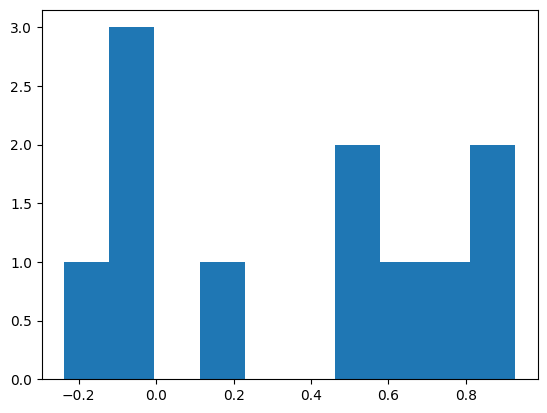

Count of cosine similarities = 11


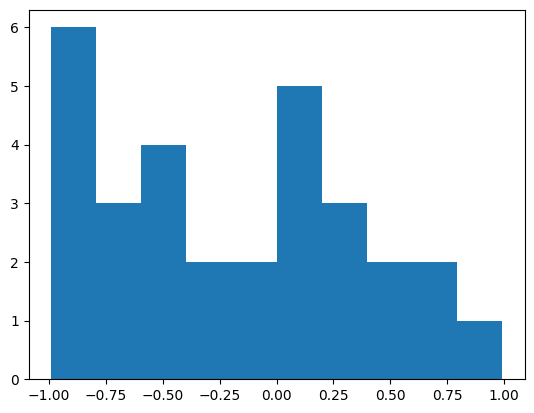

Count of cosine similarities = 30


In [9]:
test_query_dict = {
    2876: ["1.jpg", "2.jpg", "3.jpg"],
    5674: ["5.jpg"],
    864: ["9.jpg", "10.jpg"],
}
test_query_img_names = ["1.jpg", "2.jpg", "3.jpg", "5.jpg", "9.jpg", "10.jpg"]
test_query_img_names = [os.path.join(CFG.img_folder_dst, x) for x in test_query_img_names]

test_query_embeddings = [
    [1.56, 6.45, -7.68],
    [-1.1, 6.11, -3.0],
    [-0.06, -0.98, -1.29],
    [8.56, 1.45, 1.11],
    [0.7, 1.1, -7.56],
    [0.05, 0.9, -2.56],
]

test_distractors_img_names = ["11.jpg", "12.jpg", "13.jpg", "14.jpg", "15.jpg"]
test_distractors_img_names = [os.path.join(CFG.img_folder_dst, x) for x in test_distractors_img_names]

test_distractors_embeddings = [
    [0.12, -3.23, -5.55],
    [-1, -0.01, 1.22],
    [0.06, -0.23, 1.34],
    [-6.6, 1.45, -1.45],
    [0.89, 1.98, 1.45],
]
test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names, test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names, test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings, test_distractors_embeddings)

In [10]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604, -0.18355866977496182, 0.9787437979250561]
assert np.allclose(
    sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)
), "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [
    0.15963231223161822,
    0.8507997093616965,
    0.9272761484302097,
    -0.0643994061127092,
    0.5412660901220571,
    0.701307100338029,
    -0.2372575528216902,
    0.6941032794522218,
    0.549425446066643,
    -0.011982733001947084,
    -0.0466679194884999,
]
assert np.allclose(
    sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)
), "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [
    0.3371426578637511,
    -0.6866465610863652,
    -0.8456563512871669,
    0.14530087113136106,
    0.11410510307646118,
    -0.07265097629002357,
    -0.24097699660707042,
    -0.5851992679925766,
    0.4295494455718534,
    0.37604478596058194,
    0.9909483738948858,
    -0.5881093317868022,
    -0.6829712976642919,
    0.07546364489032083,
    -0.9130970963915521,
    -0.17463101988684684,
    -0.5229363015558941,
    0.1399896725311533,
    -0.9258034013399499,
    0.5295114163723346,
    0.7811585442749943,
    -0.8208760031249596,
    -0.9905139680301821,
    0.14969764653247228,
    -0.40749654525418444,
    0.648660814944824,
    -0.7432584300096284,
    -0.9839696492435877,
    0.2498741082804709,
    -0.2661183373780491,
]
assert np.allclose(
    sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)
), "A mistake in compute_cosine_query_distractors function"

In [11]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
    x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg, test_cosine_query_distractors, fpr=fpr)
    test_thr.append(x)
    test_tpr.append(y)

In [12]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"